# LMC outputs
Exploratory data analysis: Compares the number and recipients of inputs from LMCs. Only L2 and L1 were found to have presynaptic terminals in the lamina. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression

from vis.hex_lattice import hexplot
from vis.fig_tools import linear_cmap, subtype_cm

In [25]:
tp = '210615'
link_df = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
link_df = link_df.loc[[i for i, row in link_df.iterrows() if row['pre_om'] == row['post_om']]]
subtypes = np.unique([*link_df["pre_type"], *link_df["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = np.unique(link_df['pre_om'])

In [50]:
plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs = False
fig_path = '/mnt/home/nchua/Dropbox/lamina_figures/210714/'
##################
# if save_figs:
#     fig.savefig(fig_path + 'FNAME.svg')
#     fig.savefig(fig_path + 'FNAME..png')
c = subtype_cm()

In [26]:
# df_lamina = pd.DataFrame(index=ommatidia, columns=all_ctype_labels).astype('Int64')

# for om, row in df_lamina.iterrows():
#     for c in all_ctype_labels:
#         pre_t, post_t = c.split('->')
#         # Cartridges on the posterior edge lack L4, so their counts for these connections are NaNed 
#         if om in ['B0', 'E4', 'E5', 'E6', 'E7', 'D2', 'C1'] and post_t == 'LMC_4':
#             df_lamina.loc[om, c] = None
#         else:
#             df_lamina.loc[om, c] = sum((link_df.pre_om == om) & (link_df.post_om == om) & 
#                                        (link_df.pre_type == pre_t) & (link_df.post_type == post_t))


In [51]:
#df_presites = pd.DataFrame(index=om_list, columns=all_vfs)
#df_outputs = pd.DataFrame(index=om_list, columns=all_vfs)
lmcs = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']
# long form dataframe with multiindex (om x svf subtype) might be easier to use
long = pd.DataFrame(index=pd.MultiIndex.from_product([ommatidia, lmcs], names=['om', 'pre_type']))

for (om, st), row in long.iterrows():
    these_links = link_df.loc[(link_df.pre_om == om) & (link_df.pre_type == st)]
    links_to_lmcs = these_links.loc[[i for i, row in these_links.iterrows() if row.post_type[0:3] == 'LMC']]
    #print(len(these_links))
    long.loc[(om, st), 'out_to_all'] = len(these_links)
    long.loc[(om, st), 'out_to_lmc'] = len(links_to_lmcs)
    long.loc[(om, st), 'pre_sites'] = len(these_links.cx_id.unique())
long.head()

out_to_all  out_to_lmc  pre_sites
om pre_type                                   
A0 LMC_1            0.0         0.0        0.0
   LMC_2           54.0        41.0       12.0
   LMC_3            0.0         0.0        0.0
   LMC_4            0.0         0.0        0.0
   LMC_N            8.0         7.0        2.0

'LMC_1'

'LMC_2'

'LMC_3'

'LMC_4'

'LMC_N'

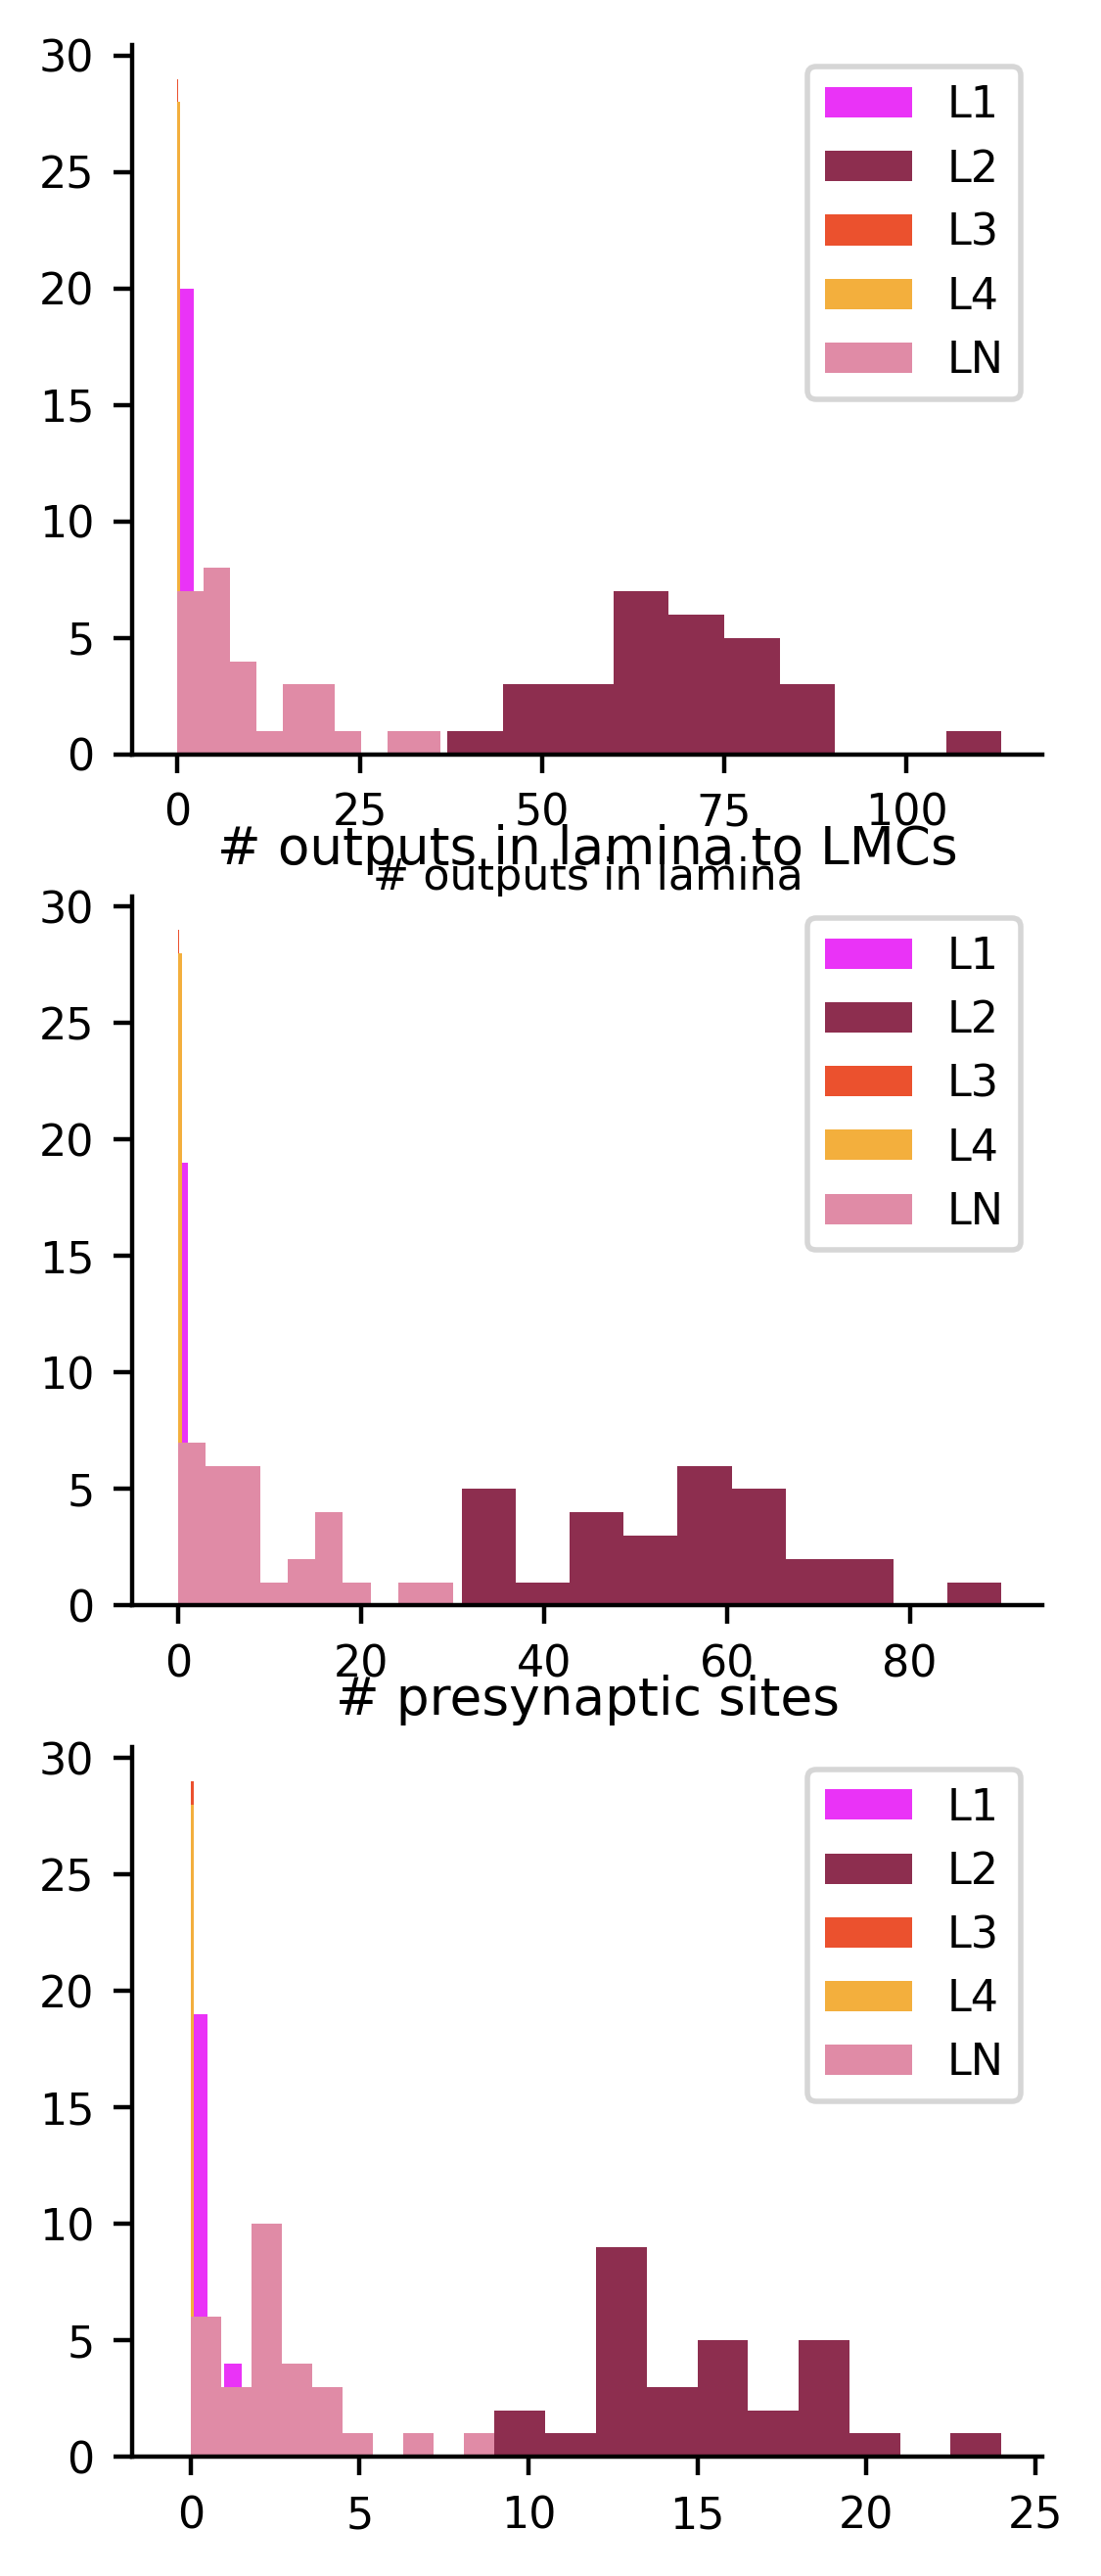

In [63]:
fig, ax = plt.subplots(3, figsize=[3, 8])
for pre, rows in long.groupby('pre_type'):
    display(pre)
    ax[0].hist(rows.out_to_all, color=c[pre], label=pre[0] + pre[-1])
    ax[1].hist(rows.out_to_lmc, color=c[pre], label=pre[0] + pre[-1])
    ax[2].hist(rows.pre_sites, color=c[pre], label=pre[0] + pre[-1])
ax[0].set_xlabel('# outputs in lamina')
ax[1].set_title('# outputs in lamina to LMCs')
ax[2].set_title('# presynaptic sites')
ax[0].legend()
ax[1].legend()
ax[2].legend()

'LMC_1'

'LMC_2'

'LMC_3'

'LMC_4'

'LMC_N'

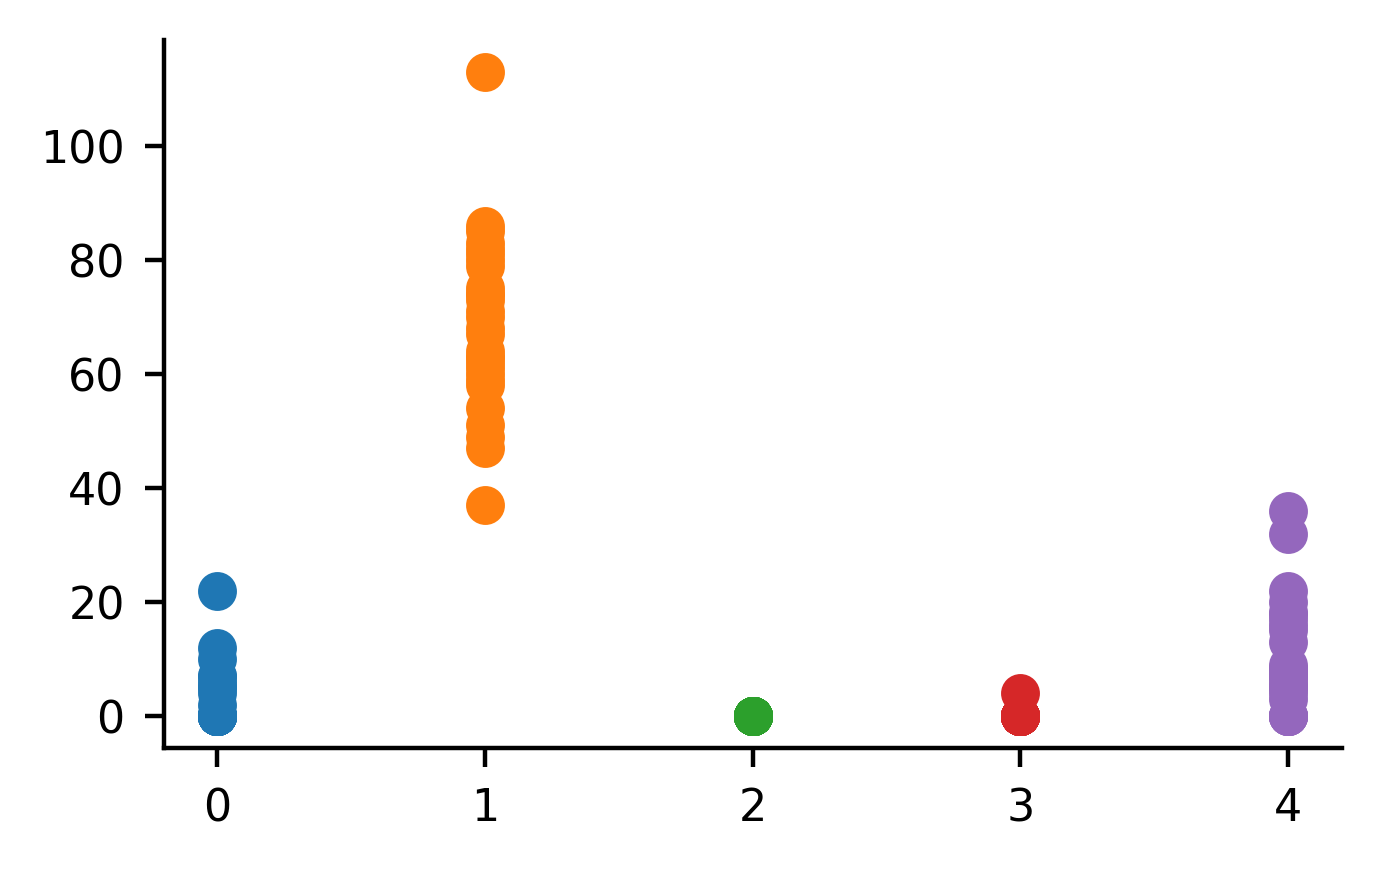

In [78]:
fig, ax = plt.subplots(1)
lmc_order = {k: i for i, k in enumerate(lmcs)}
for pre, rows in long.groupby('pre_type'):
    display(pre)
    ax.scatter(x=[lmc_order[pre] for i in range(len(rows))], y=rows.out_to_all, label=pre[0] + pre[-1])


In [5]:
# Uses neuron name to query list of connections since pretype combines svfs pairs
for om in ommatidia:
    for pre in lmcs:
        neuron_name = f"om{om}_{s}"
        if om == 'C2':
            neuron_name += '_nc'
            
        links = lamina_links.loc[lamina_links['pre_neuron'] == neuron_name]
        lmc_links = links.loc[[i for i, v in links['post_type'].items() if v[0:3] == 'LMC']]
        c_ids = links['cx_id'].unique()
#         df_presites.loc[om, s] = len(c_ids)
#         df_outputs.loc[om, s] = len(links)
        
        long.loc[(om, s), 'presites'] = len(c_ids)
        long.loc[(om, s), 'syn'] = len(links)
        long.loc[(om, s), 'lmc_syn'] = len(lmc_links)
        for l in lmcs:
            long.loc[(om, s), f'->{l}'] = len(links.loc[[i for i, v in links['post_type'].items() if v == l]])
        if len(links) > 0 and s in svfs:
            long.loc[(om, s), 'syn_multi'] = len(links)/len(c_ids)
        elif len(links) > 0 and s not in svfs:
            long.loc[(om, s), 'syn_multi'] = len(links)/len(c_ids)
            display('Long photoreceptor has more than zero connections in the lamina. Check if this is real')
            #display(links)
        else:
            # When links are 0 (lvfs), multiplicity is NaN
            long.loc[(om, s), 'syn_multi'] = np.nan

'Long photoreceptor has more than zero connections in the lamina. Check if this is real'

,link_id,cx_id,pre_neuron,pre_om,pre_type,pre_skel,post_neuron,post_om,post_type,post_skel
13364,228363,328663,omB0_R7p,B0,R7p,216709,omB0_R5,B0,R2R5,214441
13365,228356,328663,omB0_R7p,B0,R7p,216709,omB0_L3,B0,LMC_3,216748
13366,228351,328663,omB0_R7p,B0,R7p,216709,omB0_L1,B0,LMC_1,216758
13367,228350,328663,omB0_R7p,B0,R7p,216709,omB0_L3,B0,LMC_3,216748
13368,228349,328663,omB0_R7p,B0,R7p,216709,omB0_R8,B0,R8,167684
13369,228348,328663,omB0_R7p,B0,R7p,216709,omB0_L2,B0,LMC_2,216753
13370,228347,328663,omB0_R7p,B0,R7p,216709,omB0_R7p,B0,R7p,216709


'Long photoreceptor has more than zero connections in the lamina. Check if this is real'

,link_id,cx_id,pre_neuron,pre_om,pre_type,pre_skel,post_neuron,post_om,post_type,post_skel
9285,272363,423249,omB5_R8,B5,R8,165923,omB5_R7,B5,R7,241264
9286,272362,423249,omB5_R8,B5,R8,165923,omB5_R7p,B5,R7p,241249


'Long photoreceptor has more than zero connections in the lamina. Check if this is real'

,link_id,cx_id,pre_neuron,pre_om,pre_type,pre_skel,post_neuron,post_om,post_type,post_skel
6647,153663,248469,omD5_R8,D5,R8,143980,omD5_R7,D5,R7,14191
6648,153649,248469,omD5_R8,D5,R8,143980,omD5_L1,D5,LMC_1,143917
6649,153650,248469,omD5_R8,D5,R8,143980,omD5_C,D5,centri,145113


# L1 outputs are sparse

In [5]:
display(df_lamina.filter(regex='UNKNOWN').sum(axis=0))

l1_out = df_lamina.filter(regex='^LMC_1->')
l1_out = l1_out[(l1_out.sum()>0).index]

l2_out = df_lamina.filter(regex='^LMC_2->')
l2_out = l2_out[(l2_out.sum()>0).index]

ln_out = df_lamina.filter(regex='^LMC_N->')
ln_out = ln_out[(ln_out.sum()>0).index]

LMC_1->UNKNOWN      0
LMC_2->UNKNOWN      0
LMC_3->UNKNOWN      0
LMC_4->UNKNOWN      0
LMC_N->UNKNOWN      0
R1R4->UNKNOWN       0
R2R5->UNKNOWN       0
R3R6->UNKNOWN       0
R7->UNKNOWN         0
R7p->UNKNOWN        0
R8->UNKNOWN         0
UNKNOWN->LMC_1      0
UNKNOWN->LMC_2      0
UNKNOWN->LMC_3      0
UNKNOWN->LMC_4      0
UNKNOWN->LMC_N      0
UNKNOWN->R1R4       0
UNKNOWN->R2R5       0
UNKNOWN->R3R6       0
UNKNOWN->R7         0
UNKNOWN->R7p        0
UNKNOWN->R8         0
UNKNOWN->UNKNOWN    0
UNKNOWN->centri     0
centri->UNKNOWN     0
dtype: int64

0.0
22.0
37.0
113.0
0.0
36.0


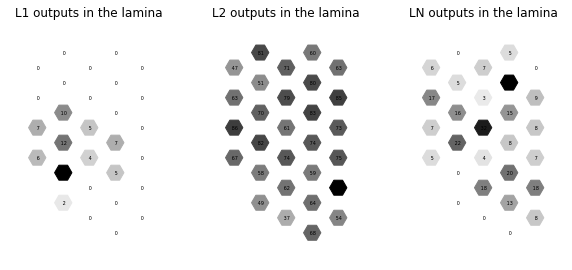

In [11]:
fig, ax = plt.subplots(1, 3, figsize=[10, 30])

cm = plt.cm.get_cmap('binary')
# L1 outputs
max_l1 = l1_out.sum(axis=1).max()
print(l1_out.sum(axis=1).min())
print(l1_out.sum(axis=1).max())
node_data = {o: {'colour': cm(l1_out.loc[o].sum()/max_l1),
                'label': f"{l1_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[0])
ax[0].set_title("L1 outputs in the lamina")
# L2 outputs 
max_l2 = l2_out.sum(axis=1).max()
print(l2_out.sum(axis=1).min())
print(l2_out.sum(axis=1).max())
node_data = {o: {'colour': cm(l2_out.loc[o].sum()/max_l2),
                'label': f"{l2_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[1])
ax[1].set_title("L2 outputs in the lamina")

max_ln = ln_out.sum(axis=1).max()
print(ln_out.sum(axis=1).min())
print(max_ln)
node_data = {o: {'colour': cm(ln_out.loc[o].sum()/max_ln),
                'label': f"{ln_out.loc[o].sum(): .0f}"
                } for o in ommatidia}
hexplot(node_data=node_data, ax=ax[2])
ax[2].set_title("LN outputs in the lamina")
plt.show()